[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AlexAndorra/football-modeling/blob/main/00_code/main__SFM_IIa.ipynb)


<h1 align="center"><strong><font size="6"> Model Estimation SFM IIa </h1></strong></font>

<br>
<br>

The **SFM IIa** is an evolution of **SFM I**. **SFM IIa** comprises a larger feature set (i.e. *more factors*) and a larger universe of players.

The **SFM I** is the model in [Andorra & Göbel (2024)](https://arxiv.org/abs/2412.05911) -- see notebook `013_SFM_Sloan__Submission.ipynb`.

<br>

**NOTE**: in SFM IIa, *player momentum* (`goalsscored_MOM_player`) is pooled across players. Hence, $\beta_{MOM}$ does not carry a player-index $i$, indicating that it is common for all players.

In [ ]:
# --- Connect to Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -------------------------------------- USER INTERACTION -------------------------------------- #

# --- Set the directory to the datafile ('SFM_data_byPlayer.csv'):
directory = '/content/drive/MyDrive/Colab Notebooks/51_SoccerAnalytics/'

# --- Which is the last season you want to Include in Training? [YYYY/YY]
train_end = '2023/24'

# --- With HSGPs or without?
use__HSGP = True

# -------------------------------------- USER INTERACTION -------------------------------------- #

In [ ]:
!pip install -qq pymc numpyro
#!pip install -qq pymc_bart
!pip install -qq preliz
!pip install -qq graphviz
!pip install -qq arviz
!pip install -qq jax[cuda] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.9/370.9 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.0/149.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 47.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.63.1 which is incompatible.
cudf-cu12 25.10.0 requires numba<0.62.0a0,>=0.60.0, but you have numba 0.63.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 61.7 MB/s eta 0:00:00


In [ ]:
from typing import List, Union

#import arviz as az
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# --- Additional Styling
#az.style.use("arviz-whitegrid")
#plt.rcParams["figure.figsize"] = [12, 5]
#%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "sfm"))
rng = np.random.default_rng(seed)

pm.__version__

'5.26.1'

In [ ]:
np.__version__

'2.0.2'

## 00 &emsp; Data preparation

In [ ]:
# ======================================== Load the Data ======================================== #


#complete_data = pd.read_csv(f"{directory}/10_data/106_Website/data_byPlayer.csv")
complete_data = pd.read_csv(f"{directory}/10_data/106_Website/data_byPlayer__SFM_II.csv")

# --- Pre-Processing, Part I:
complete_data['kick_off'] = pd.to_datetime(complete_data['kick_off'])
complete_data = complete_data.sort_values(['name_player','season','kick_off'])
complete_data

,goal,goals_in_match,goals_in_first_half,goals_in_second_half,goals_scored_avg_minutes_left,points_team,points_opp,goalsscored_inGame_team,goalsscored_inGame_opp,goalsscored_cum_team,...,goalsscored_rank_opp,goalsconceded_rank_team,goalsscored_diff,goal_balance_team,goal_balance_opp,goal_balance_diff,points_diff,goalsscored_share_player_team,name_player,position_player
0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,0.0,4.0,4.0,...,0.0,7.5,-6.0,1.0,7.0,-6.0,-3.0,0.000000,aaron-connolly,Sturm
1,0.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,4.0,...,10.0,15.5,-1.0,-3.0,-1.0,-2.0,0.0,0.000000,aaron-connolly,Sturm
2,0.0,0.0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,...,17.0,14.0,1.0,-3.0,-4.0,1.0,1.0,0.000000,aaron-connolly,Sturm
3,0.0,0.0,0.0,0.0,0.0,6.0,8.0,0.0,2.0,5.0,...,2.5,10.0,-7.0,-3.0,-1.0,-2.0,-2.0,0.000000,aaron-connolly,Sturm
4,1.0,2.0,1.0,1.0,19.0,6.0,11.0,3.0,0.0,5.0,...,2.5,10.0,-9.0,-5.0,5.0,-10.0,-5.0,0.000000,aaron-connolly,Sturm
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345156,1.0,1.0,0.0,1.0,16.0,40.0,34.0,4.0,0.0,52.0,...,10.0,16.5,17.0,1.0,3.0,-2.0,6.0,0.153846,zvjezdan-misimovic,Mittelfeld
345157,0.0,0.0,0.0,0.0,0.0,43.0,28.0,2.0,0.0,56.0,...,15.0,15.5,28.0,5.0,-19.0,24.0,15.0,0.160714,zvjezdan-misimovic,Mittelfeld
345158,0.0,0.0,0.0,0.0,0.0,46.0,51.0,2.0,4.0,58.0,...,0.0,15.0,-5.0,7.0,26.0,-19.0,-5.0,0.155172,zvjezdan-misimovic,Mittelfeld
345159,0.0,0.0,0.0,0.0,0.0,46.0,56.0,1.0,1.0,60.0,...,5.0,15.5,8.0,4.0,14.0,-10.0,-10.0,0.150000,zvjezdan-misimovic,Mittelfeld


In [ ]:
print(f'Total Number of Players: {len(complete_data['name_player'].unique())}')


Total Number of Players: 2908


In [ ]:
# ======================================== Feature Engineering ======================================== #

# --- Goal Appeal (of the match):
complete_data['goal_appeal'] = complete_data['goalsconceded_rank_opp'] - complete_data['goalsscored_rank_team']


# ------------------------ Player Momentum: exponentially-weighted MA of previous goals ------------------------ #

# --- Calculate the Number of Goals scored in the PREVIOUS appearance -- and fill initial NAs with the cumulative number of goals:
complete_data['FD__goalsscored_cum_player'] = complete_data.groupby(['season','name_player'])['goalsscored_cum_player'].diff().fillna(complete_data['goalsscored_cum_player'])

# --- Calculate MOMENTUM: EWMA of goals scored in previous games (halflife == one appearance)
playerMomentum = pd.DataFrame(complete_data.groupby(['season','name_player'])['FD__goalsscored_cum_player'].ewm(halflife=1).mean().reset_index()).set_index('level_2')


# --- Merge:
complete_data['goalsscored_MOM_player'] = playerMomentum['FD__goalsscored_cum_player']


In [ ]:
# ======================================== Pre-Processing: Part II ======================================== #

# --- Fill missing positions: first, backward; then, forward
complete_data['position_player'] = complete_data.groupby(['season','name_player'])['position_player'].bfill().ffill()

# --- Create Dummies for positions:
complete_data['position_MID'] = np.where(complete_data['position_player'] == 'Mittelfeld',1,0)
#complete_data['position_DEF'] = np.where(complete_data['position_player'] == 'Abwehr',1,0)
complete_data['position_FOR'] = np.where(complete_data['position_player'] == 'Sturm',1,0)


In [ ]:
#complete_data.loc[complete_data['position_player'].isna(),['name_player','season','gameday','position_player']]

In [ ]:
complete_data.shape

(345161, 41)

In [ ]:
#for m in [2,3,4,8]:
#  playerMomentum = pd.DataFrame(complete_data.groupby(['season','name_player'])['FD__goalsscored_cum_player'].ewm(halflife=m).mean().reset_index()).set_index('level_2')
#  complete_data[f'goalsscored_MOM{m}_player'] = playerMomentum['FD__goalsscored_cum_player']

#features = ["points_diff",'goalsscored_cum_player','goalsconceded_rank_opp','goalsscored_share_player_team','goal_appeal'] + complete_data.filter(like='goalsscored_MOM',axis=1).columns.tolist()
#complete_data[features].corr()

In [ ]:
# ======================================== Pre-Processing: Part III ======================================== #

print(f'Number of Observations \'goalsscored_share_player_team\' > 1: {sum(complete_data['goalsscored_share_player_team'] > 1)} ')

complete_data = complete_data.loc[complete_data['goalsscored_share_player_team'] <= 1,:].reset_index(drop=True)

Number of Observations 'goalsscored_share_player_team' > 1: 6 


In [ ]:
# ======================================== Define the Factors ======================================== #

# --- Numerical Factors:
factors_CS = ["points_diff",'goalsscored_cum_player','goalsconceded_rank_opp',
              'goalsscored_share_player_team','goal_appeal']
# --- Other Factors:
other_factors = ["home_pitch",'position_MID','position_FOR','goalsscored_MOM_player']

# --- Concatenate:
factors = other_factors + factors_CS
factors_team = list(set(other_factors + factors_CS) - set(['goalsscored_MOM_player']))
factors_player = ['goalsscored_MOM_player']

In [ ]:
# ======================================== Some Data Preprocessing ======================================== #

# --- 0.2 Get the Training-Data only:
complete_data = complete_data[complete_data.season <= train_end]


# --- 0.3 Some Type-Setting:
complete_data["goal"] = complete_data["goal"].astype(int)
complete_data["goals_in_match"] = complete_data["goals_in_match"].astype(int)

complete_data["kick_off"] = pd.to_datetime(
    complete_data["kick_off"], yearfirst=True
).dt.normalize()


# --- 0.4 Player-Maturity: compute season number for each player
complete_data["season_nbr"] = complete_data.groupby(["name_player"])[
    "season"
].transform(lambda x: x.factorize(sort=True)[0])




# --- 0.5 Final Sorting for Convenience:
complete_data = complete_data.sort_values(["name_player", "kick_off"]).reset_index(
    drop=True
)
complete_data

,goal,goals_in_match,goals_in_first_half,goals_in_second_half,goals_scored_avg_minutes_left,points_team,points_opp,goalsscored_inGame_team,goalsscored_inGame_opp,goalsscored_cum_team,...,points_diff,goalsscored_share_player_team,name_player,position_player,goal_appeal,FD__goalsscored_cum_player,goalsscored_MOM_player,position_MID,position_FOR,season_nbr
0,0,0,0.0,0.0,0.0,4.0,7.0,0.0,4.0,4.0,...,-3.0,0.000000,aaron-connolly,Sturm,-1.0,0.0,0.000000,0,1,0
1,0,0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,4.0,...,0.0,0.000000,aaron-connolly,Sturm,-2.0,0.0,0.000000,0,1,0
2,0,0,0.0,0.0,0.0,5.0,4.0,0.0,0.0,5.0,...,1.0,0.000000,aaron-connolly,Sturm,0.5,0.0,0.000000,0,1,0
3,0,0,0.0,0.0,0.0,6.0,8.0,0.0,2.0,5.0,...,-2.0,0.000000,aaron-connolly,Sturm,2.5,0.0,0.000000,0,1,0
4,1,2,1.0,1.0,19.0,6.0,11.0,3.0,0.0,5.0,...,-5.0,0.000000,aaron-connolly,Sturm,-9.0,0.0,0.000000,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328198,1,1,0.0,1.0,16.0,40.0,34.0,4.0,0.0,52.0,...,6.0,0.153846,zvjezdan-misimovic,Mittelfeld,1.0,0.0,0.187547,1,0,6
328199,0,0,0.0,0.0,0.0,43.0,28.0,2.0,0.0,56.0,...,15.0,0.160714,zvjezdan-misimovic,Mittelfeld,9.0,1.0,0.593774,1,0,6
328200,0,0,0.0,0.0,0.0,46.0,51.0,2.0,4.0,58.0,...,-5.0,0.155172,zvjezdan-misimovic,Mittelfeld,4.5,0.0,0.296887,1,0,6
328201,0,0,0.0,0.0,0.0,46.0,56.0,1.0,1.0,60.0,...,-10.0,0.150000,zvjezdan-misimovic,Mittelfeld,1.5,0.0,0.148443,1,0,6


In [ ]:
# ======================================== Number of Players ======================================== #


players_ordered = complete_data["name_player"].sort_values().unique()
players_ordered.shape

(2850,)

In [ ]:
# ======================================== Just some Checking ======================================== #

assert complete_data["name_player"].sort_values().unique().shape[0] == len(
    players_ordered
)

## 00 &emsp; Some Data-Inspection

In [ ]:
# ======================================== Share of Goals ======================================== #


complete_data["goals_in_match"].value_counts(normalize=True).round(4)

,proportion
goals_in_match,
0,0.8263
1,0.1505
2,0.0204
3,0.0026
4,0.0003
5,0.0000


In [ ]:
# ======================================== Frequency of Goals ======================================== #

complete_data["goals_in_match"].value_counts()

,count
goals_in_match,
0,271196
1,49382
2,6687
3,845
4,84
5,9


In [ ]:
# ======================================== Winsorization of Goals >= 3 ======================================== #

complete_data["goals_cats"] = np.where(
    complete_data["goals_in_match"] >= 3, 3, complete_data["goals_in_match"]
)


In [ ]:
complete_data[factors_CS]

,points_diff,goalsscored_cum_player,goalsconceded_rank_opp,goalsscored_share_player_team,goal_appeal
0,-3.0,0.0,7.5,0.000000,-1.0
1,0.0,0.0,12.0,0.000000,-2.0
2,1.0,0.0,14.0,0.000000,0.5
3,-2.0,0.0,18.0,0.000000,2.5
4,-5.0,0.0,8.0,0.000000,-9.0
...,...,...,...,...,...
328198,6.0,8.0,4.0,0.153846,1.0
328199,15.0,9.0,12.0,0.160714,9.0
328200,-5.0,9.0,7.0,0.155172,4.5
328201,-10.0,9.0,4.5,0.150000,1.5


In [ ]:
# ======================================== Cross-Sectional Standardization (by Gameday) ======================================== #


data__scaleCS = complete_data.groupby('gameday')[factors_CS].apply(lambda x: (x - x.mean()) / x.std()).reset_index().set_index('level_1').drop('gameday',axis=1)


# --- Merge:
complete_data[factors_CS] = data__scaleCS


In [ ]:
complete_data[factors_CS]

,points_diff,goalsscored_cum_player,goalsconceded_rank_opp,goalsscored_share_player_team,goal_appeal
0,-0.942005,-0.614919,-0.492962,-0.592733,-0.311176
1,-0.071268,-0.669871,0.304340,-0.658594,-0.466521
2,0.143735,-0.721235,0.673496,-0.722839,-0.132818
3,-0.461552,-0.766425,1.384758,-0.777670,0.119277
4,-0.969389,-0.804919,-0.395006,-0.823659,-1.395772
...,...,...,...,...,...
328198,0.235488,0.922939,-1.128525,0.458061,-0.093571
328199,0.708521,1.088789,0.315589,0.528949,0.919258
328200,-0.362967,1.004943,-0.585835,0.463903,0.353222
328201,-0.588521,0.900216,-1.026494,0.430895,-0.034574


## 1 &emsp; Feature Engineering

In [ ]:
# ======================================== 1.1 Factor Standardization ======================================== #

if 1==2:
    factors_CS_train = complete_data[factors_CS]

    # --- Do the Standardization
    scaler = StandardScaler()
    factors_CS_sdz = pd.DataFrame(
        scaler.fit_transform(factors_CS_train), columns=factors_CS
    )

    # --- Add the non-numeric factor to the standardized DataFrame
    factors_sdz = factors_CS_sdz.copy()
    factors_sdz[other_factors] = complete_data[other_factors]

    # --- Ensure that the order is the same as the PyMC coords later on
    factors_sdz = factors_sdz[factors]


else:

    # --- No Standardization -- Ensure that the order is the same as the PyMC coords later on:
    factors_sdz = complete_data[factors].copy()



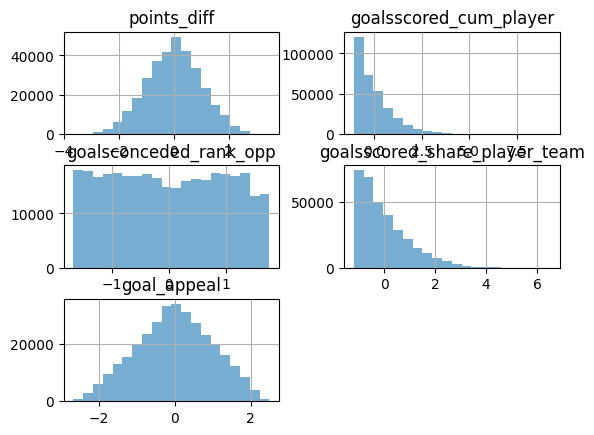

In [ ]:
factors_sdz[factors_CS].hist(alpha=0.6, bins=20);

## 2 &emsp; HSGP Parameters

In the model below, we use a linear trend on the season term for each player. That's because we assume that the effects of maturity, as we call it, are mostly non-linear for each player: all else being equal, we don't expect players to _suddenly_ become very good or very bad.

Once we've taken this trend into account though, we do envision possibilities for the goal performance of a player to exhibit non-linear fluctuations (they got injured and don't come back well; they didn't prepare well enough during the summer and lag behind in the second half of the season; on the contrary, they prepared too intensely during the summer and are exhausted once Spring arrives, etc.).

To handle these effects, we'll use the new [Hilbert-Space decomposition](https://arxiv.org/abs/2004.11408) of the Gaussian Process (HSGP), which is also [available in PyMC](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html). So instead of using a classic linear trend on `days_since_first_week` (as we do on `season`), we'll use an HSGP.

### 2.1 &emsp; Choosing the approximation parameters

HSGP is mainly defined by two parameters, `m` and `c`, respectively the number of basis vectors and the multiplier determining the boundary of the approximation (see [this](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) for more details). PyMC actually has a helper function to help us choose `m` and `c`:

In [ ]:
# ==================================== Intra-Season Fluctuations ==================================== #
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.gameday.max()],
    lengthscale_range=[5, 25],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m) --- Intra-Season:", m_within)
print("Recommended smallest scaling factor (c) --- Intra-Season:",          np.round(c_within, 1))


# ==================================== Inter-Season Fluctuations ==================================== #
m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, 30], #complete_data.season_nbr.max()],
    lengthscale_range=[2, 6],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m) --- Inter-Season:", m_long)
print("Recommended smallest scaling factor (c) --- Inter-Season:",          np.round(c_long, 1))

Recommended smallest number of basis vectors (m) --- Intra-Season: 54
Recommended smallest scaling factor (c) --- Intra-Season: 5.4
Recommended smallest number of basis vectors (m) --- Inter-Season: 32
Recommended smallest scaling factor (c) --- Inter-Season: 1.6


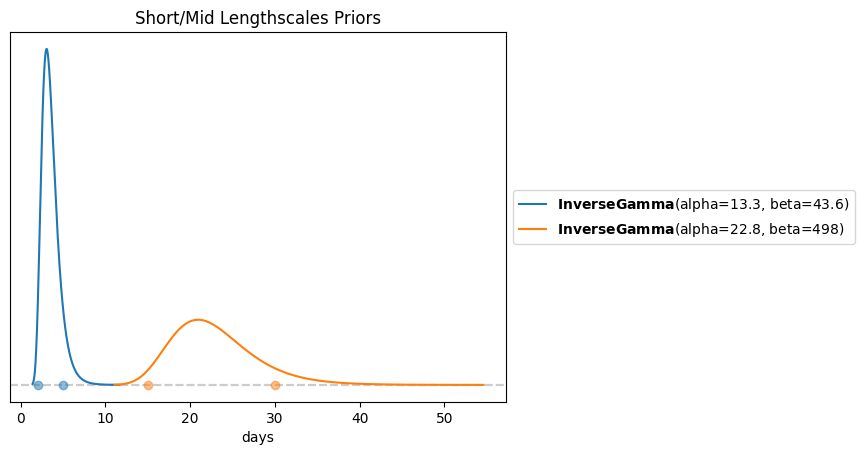

In [ ]:
ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
ls_medium_dist, ax = pz.maxent(pz.InverseGamma(), 15, 30)
ax.set(title="Short/Mid Lengthscales Priors", xlabel="days");

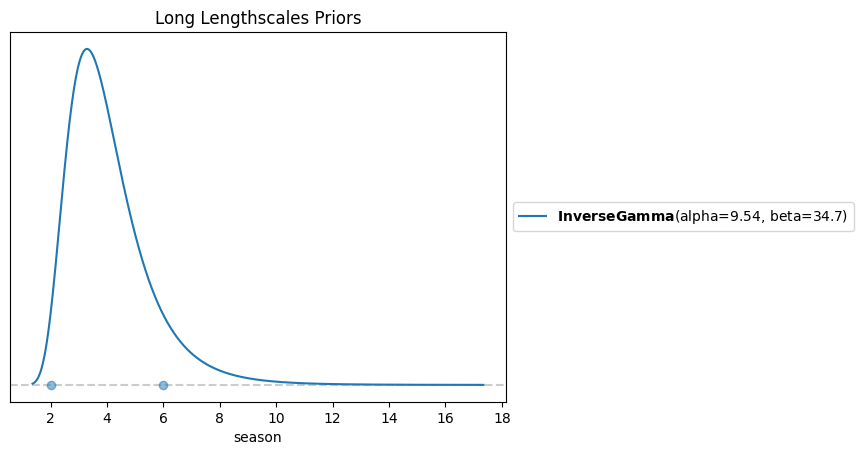

In [ ]:
ls_long_dist, ax = pz.maxent(pz.InverseGamma(), 2, 6)
ax.set(title="Long Lengthscales Priors", xlabel="season");

We can now implement our PyMC model. It'll be a big one, but we'll take it step by step.

## 3 &emsp; PyMC Model

### 3.1 &emsp; Variable Definition to set the PyMC Model

In [ ]:
# =========================== Static Variables for Train- & Test-Set =========================== #

#unique_gamedays = complete_data["gameday"].sort_values().unique()
#unique_seasons = complete_data["season_nbr"].sort_values().unique()

unique_gamedays = np.arange(1,39)
unique_seasons = np.arange(0,31)


In [ ]:
# =========================== Changing Variables for Train- & Test-Set =========================== #

# --- Index for Players:
player_idx = pd.Categorical(
    complete_data["name_player"], categories=players_ordered
).codes

# --- Index for Game Days:
gameday_idx = pd.Categorical(
    complete_data["gameday"],
    categories=unique_gamedays,
).codes

# --- Set the Coords:
COORDS = {
    "event": complete_data["goals_cats"].factorize(sort=True)[1],
    "factor": factors,
    "factor_team": factors_team,
    "factor_player": factors_player,
    "gameday": unique_gamedays,
    "obs_id": complete_data.index,
    "player": players_ordered,
    "season": unique_seasons,
    "timescale": ["short", "medium", "long"],
}

Then, let's define the data containers for our model:

### 3.2 &emsp; Set the Model

In [ ]:
with pm.Model(coords=COORDS) as SFM_IIa:

    # Data containers
    #factor_data = pm.Data(
    #    "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    #)
    factor_data__team = pm.Data(
        "factor_data__team", factors_sdz[factors_team].to_numpy(), dims=("obs_id", "factor_team")
    )
    factor_data__player = pm.Data(
        "factor_data__player", factors_sdz[factors_player].to_numpy(), dims=("obs_id", "factor_player")
    )
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data(
        "season_id", complete_data["season_nbr"].to_numpy(), dims="obs_id"
    )
    goals_obs = pm.Data(
        "goals_obs", complete_data["goals_cats"].to_numpy(), dims="obs_id"
    )

In [ ]:
# ========================================= Player's Skill: alpha ========================================= #

if use__HSGP:

    with SFM_IIa:


        # ---------------------------------- Player's Baseline Skill ---------------------------------- #

        #  A Player's Baseline Skill is modelled as: Some Baseline Skill + Zero-Sum Normal
        #
        #

        # --- Baseline Skill
        intercept_sigma = 5
        sd = pm.Exponential("player_effect_diversity", 1)

        baseline_sigma = pt.sqrt(intercept_sigma**2 + sd**2 / len(COORDS["player"]))
        baseline = baseline_sigma * pm.Normal("baseline")


        # --- Player-Effect: Baseline + Zero-Sum Normal
        player_effect = pm.Deterministic(
            "player_effect",
            baseline + pm.ZeroSumNormal("player_effect_raw", sigma=sd, dims="player"),
            dims="player",
        )



        # ---------------------------------- Maturity Effects (via HSGPs) ---------------------------------- #
        X_gamedays = pm.Data("X_gamedays", unique_gamedays, dims="gameday")[:, None]
        X_seasons = pm.Data("X_seasons", unique_seasons, dims="season")[:, None]

        ## 1% chance that amplitude > 2 goals
        alpha_scale, upper_scale = 0.01, 2.0
        amplitude = pm.Exponential(
            "amplitude", lam=-np.log(alpha_scale) / upper_scale, dims="timescale"
        )
        ls = pm.InverseGamma(
            "ls",
            alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
            beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
            dims="timescale",
        )

        # cov matrices
        cov_short = amplitude[0] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
        cov_medium = amplitude[1] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
        cov_within = cov_short + cov_medium
        cov_long = amplitude[2] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])

        ## GPs
        gp_within = pm.gp.HSGP(m=[m_within], c=c_within, cov_func=cov_within)
        basis_vectors_within, sqrt_psd_within = gp_within.prior_linearized(X=X_gamedays)
        basis_coeffs_within = pm.Normal(
            "basis_coeffs_within", shape=gp_within.n_basis_vectors
        )
        f_within = pm.Deterministic(
            "f_within",
            basis_vectors_within @ (basis_coeffs_within * sqrt_psd_within),
            dims="gameday",
        )

        gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long)
        basis_vectors_long, sqrt_psd_long = gp_long.prior_linearized(X=X_seasons)
        basis_coeffs_long = pm.Normal("basis_coeffs_long", shape=gp_long.n_basis_vectors)
        f_long = pm.Deterministic(
            "f_long",
            basis_vectors_long @ (basis_coeffs_long * sqrt_psd_long),
            dims="season",
        )


        # ---------------------------------- alpha ---------------------------------- #
        alpha = pm.Deterministic(
            "alpha",
            player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
            dims="obs_id",
        )



In [ ]:
# ========================================= Player's Baseline Skill ========================================= #

if not use__HSGP:

    with SFM_IIa:


        #  A Player's Baseline Skill is modelled as: Some Baseline Skill + Zero-Sum Normal
        #
        #

        # --- Baseline Skill
        #intercept_sigma = 5
        #sd = pm.Exponential("player_effect_diversity", 1)

        #baseline_sigma = pt.sqrt(intercept_sigma**2 + sd**2 / len(COORDS["player"]))
        #baseline = baseline_sigma * pm.Normal("baseline", dims='player')
        sd_baseline = pm.Exponential("sd_baseline", 1)
        baseline = pm.Normal("baseline", mu=0, sigma=sd_baseline, dims='player')

        # --- Player-Effect: Baseline + Zero-Sum Normal
        player_effect = pm.Deterministic(
            "player_effect",
            baseline, # + pm.ZeroSumNormal("player_effect_raw", sigma=sd, dims="player"),
            dims="player",
        )


        alpha = pm.Deterministic(
            "alpha",
            player_effect[player_id],
            dims="obs_id",
        )



In [ ]:
# ========================================= The Team-Factors ========================================= #


with SFM_IIa:

    # --- Team Factors are partially pooled across teams
    #slope = pm.Normal("slope", sigma=2.5, dims="factor")
    beta__team = pm.Normal("beta__team", sigma=2.5, dims="factor_team")
    #beta__player = pm.Normal("beta__player", sigma=2.5, dims=("player",'factor_player'))
    beta__player = pm.Normal("beta__player", sigma=2.5, dims='factor_player')


### Likelihood

In [ ]:
# ==================== Preparation for Setting Priors for the Cutpoints of the Ordered-Logistic ==================== #


# --- Empirical Probabilities of Categories
empirical_probs = complete_data["goals_cats"].value_counts(normalize=True).to_numpy()

# --- Get cumulative probabilities except the last one (which will be 1)
cumulative_probs = empirical_probs.cumsum()[:-1]

# --- Inverse CDF of standard normal to convert to latent scale cutpoints
cutpoints_mu_standard = norm.ppf(cumulative_probs)

# --- Compute differences between cutpoints
delta_prior = np.diff(cutpoints_mu_standard)

In [ ]:
# ==================== Set the Model: Bayesian Time-Series Regression (Classificatuion) ==================== #


with SFM_IIa:

    # --- Conditional Mean:
    #eta = pm.Deterministic(
    #    "eta", alpha + pm.math.dot(factor_data, slope), dims="obs_id"
    #)

    eta = pm.Deterministic(
        #"eta", alpha + (factor_data__player * beta__player[player_id,:]).sum(axis=-1) + pm.math.dot(factor_data__team, beta__team), dims="obs_id"
        "eta", alpha + (factor_data__player * beta__player).sum(axis=-1) + pm.math.dot(factor_data__team, beta__team), dims="obs_id"
    )


    # --- Hyperpriors for the differences between cutpoints (delta)
    cutpoint_offset = 4
    # --- --- Mean of differences across all players
    delta_mean = pm.Normal(
        "delta_mean", mu=delta_prior * cutpoint_offset, sigma=1, shape=2
    )
    # --- --- Variation of the differences
    delta_sigma = pm.Exponential(
        "delta_sigma", 1, shape=2
    )

    # --- Player-specific differences (delta)
    delta_player = delta_mean + delta_sigma * pm.Normal(
        "delta_player", shape=(len(COORDS["player"]), 2)
    )

    # Cumulative sum to construct cutpoints
    # Ensure differences are positive using softplus
    # dims=("player", "cutpoint")
    cutpoints = pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                pt.full((player_effect.shape[0], 1), cutpoint_offset),
                pt.cumsum(pt.softplus(delta_player), axis=-1) + cutpoint_offset,
            ],
            axis=-1,
        ),  # Start at cutpoint_offset and sum differences
    )

    # --- Likelihood:
    pm.OrderedLogistic(
        "goals_scored",
        cutpoints=cutpoints[player_id],
        eta=eta,
        observed=goals_obs,
        dims="obs_id",
    )

### 3.3 &emsp; Model graph

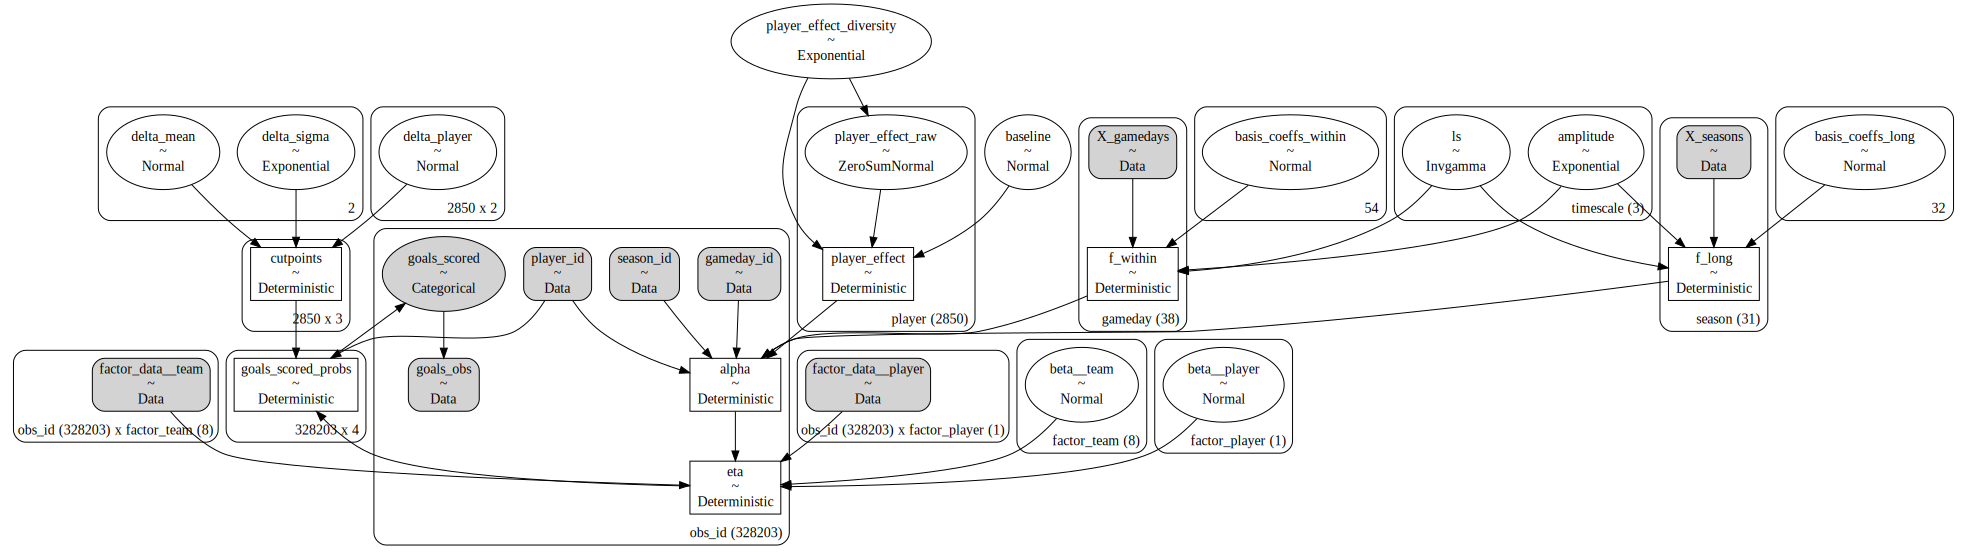

In [ ]:
pm.model_to_graphviz(SFM_IIa)

### 3.5 &emsp; Prior Predictive Sampling

In [ ]:
#with SFM_I:
#    idata = pm.sample_prior_predictive()

## 4 &emsp; Inference!

In [ ]:
# ============================================= Inference! ============================================= #


# --- In the paper we use 4 chains
# --- Just for speed: set it to 1
N_chains = 2

with SFM_IIa:
    #idata.extend(pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=N_chains))
    idata = pm.sample(nuts_sampler="numpyro",
                      target_accept=0.99,
                      chains=N_chains,
                      cores=1,  # --- CPU cores (irrelevant for GPU)
                      nuts_sampler_kwargs={"chain_method": "vectorized"})  # --- Runs chains in parallel on GPU)


sample: 100%|██████████| 2000/2000 [59:47<00:00,  1.79s/it]
/usr/local/lib/python3.12/dist-packages/jax/_src/interpreters/mlir.py:1334: UserWarning: Some donated buffers were not usable: float64[2,1000,2849].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
# ============================= Some Preparation for Post-Estimation Processing ============================= #

mindex_coords_original = xr.Coordinates.from_pandas_multiindex(
    complete_data.set_index(["name_player", "season", "gameday"]).index,
    "obs_id",
)

#idata.prior = idata.prior.assign_coords(mindex_coords_original)
#idata.prior_predictive = idata.prior_predictive.assign_coords(mindex_coords_original)
idata.observed_data = idata.observed_data.assign_coords(mindex_coords_original)


with SFM_IIa:
    idata.extend(pm.sample_posterior_predictive(idata))

Output()

In [ ]:
#idata.prior = idata.prior.reset_index("obs_id")
#idata.prior_predictive = idata.prior_predictive.reset_index("obs_id")
idata.observed_data = idata.observed_data.reset_index("obs_id")

In [ ]:
if not use__HSGP:
    import pickle
    import cloudpickle
    pickle_filepath = f'{directory}/10_data/01_Models/SFM_IIa_scaleCS__{train_end[2:4]}{train_end[-2:]}.pkl'
    dict_to_save = {'model': SFM_IIa,
                    'idata': idata,
                    'factor_standardize':factors_CS,
                    'params_HSGP' : None,
                    'indices': {'seasons':{'unique':unique_seasons,'idx':[]},
                                'players':{'unique':players_ordered,'idx':player_idx},
                                'gamedays':{'unique':unique_gamedays,'idx':gameday_idx}},
                    'data':complete_data
                   }

    with open(pickle_filepath , 'wb') as f:
        cloudpickle.dump(dict_to_save, f)

else:

    import pickle
    import cloudpickle
    pickle_filepath = f'{directory}/10_data/01_Models/SFM_IIa_scaleCS_HSGP__{train_end[2:4]}{train_end[-2:]}.pkl'
    dict_to_save = {'model': SFM_IIa,
                    'idata': idata,
                    'factor_standardize':factors_CS,
                    'params_HSGP' : {'lengthscales': {'short': ls_short_dist, 'medium': ls_medium_dist, 'long': ls_long_dist},
                                     'basis_vectors': {'within': m_within, 'long': m_long},
                                     'scaling_factors': {'within': c_within, 'long': c_long}
                                    },
                    'indices': {'seasons':{'unique':unique_seasons,'idx':[]},
                                'players':{'unique':players_ordered,'idx':player_idx},
                                'gamedays':{'unique':unique_gamedays,'idx':gameday_idx}},
                    'data':complete_data
                   }

    with open(pickle_filepath , 'wb') as f:
        cloudpickle.dump(dict_to_save, f)

In [ ]:
list(players_ordered).index('cristiano-ronaldo')

527